In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import os
import tensorflow as tf
import numpy as np
import cv2
import time
import tifffile
import matplotlib.pyplot as plt
!pip install sewar
from PIL import Image
import skimage.measure  
import skimage.measure
import pywt
from math import log10, sqrt
import cv2
import numpy as np
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb 
  



  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=f40881290bce49ddaa9fc03bde87ed184114d031060829b1f771f5ba1bdf7183
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/ProjectWork')

In [5]:
print(os.listdir())

['PanGan_2.py', 'ops.py', 'README.md', 'hist_match.m', 'compute_res.py', 'PanGan.py', 'pan_2_512.mat', 'ms_2_512.mat', 'ms_2_512.pkl', 'pan_2_512.pkl', 'task1.ipynb', 'roughexp.ipynb', 'DWT.ipynb', 'testexprgb.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb', 'image2.ipynb', 'image3.ipynb', 'SampleGAN.ipynb', 'data', 'DataSet.py', 'train.py', 'test2.py', 'result', 'config.py', '__pycache__', 'log_06_02-generator', 'model_06_02-generator', 'ms0.tif', 'parameters.ipynb', 'xideapetrovic.py', 'image1.ipynb', 'samplePhase1.ipynb', 'Phase1.ipynb', 'PanGan_b.py', 'train_pf.py', 'crop8bit_1.npy', 'crop8bit_2.npy', 'crop8bit_3.npy', 'crop8bit_4.npy', 'crop8bit_5.npy', 'crop8bit_6.npy', 'crop8bit_7.npy', 'crop8bit_8.npy', 'crop8bit_9.npy', 'crop8bit_10.npy', 'crop8bit_11.npy', 'crop8bit_12.npy', 'crop8bit_13.npy', 'crop8bit_14.npy', 'crop8bit_15.npy', 'crop8bit_16.npy', 'crop8bit_17.npy', 'crop8bit_18.npy', 'crop8bit_19.npy', 'crop8bit_20.npy', 'crop8bit_21.npy', 'crop8bit_22.npy', 'crop8bit_23.npy'

In [6]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [7]:
def read_img(pan_test_path, ms_test_path, img_name, FLAGS):
    pan_img_path=os.path.join(pan_test_path, img_name)
    ms_img_path=os.path.join(ms_test_path, img_name)
    #pan_img=cv2.imread(pan_img_path, -1)
    #pan_img=gdal_read(pan_img_path,'pan')
    pan_img=read8bit(pan_img_path,'pan')
    h,w=pan_img.shape
    pan_img=pan_img.reshape((1,h,w,1))
    #ms_img=cv2.imread(ms_img_path, -1)
    #ms_img=gdal_read(ms_img_path,'ms')
    ms_img=read8bit(ms_img_path,'ms')
    h,w,c=ms_img.shape
    ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    h,w,c=ms_img.shape
    
    # ms_img=np.array(ms_img)
    # h,w,c=ms_img.shape
    # ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    ms_img=ms_img.reshape((1,h,w,c))
   
    return pan_img, ms_img


In [8]:
def gdal_read(path,name):
    data=gdal.Open(path)
    w=data.RasterXSize
    h=data.RasterYSize
    img=data.ReadAsArray(0,0,w,h)
    if name == 'ms':
        img=np.transpose(img,(1,2,0))
    img=(img-1023.5)/1023.5
    return img


In [9]:
def read8bit(path,name):
    if name=='ms':
        v='src'
    else:
        v='pan'
    v='I'
    #img=scio.loadmat(path)[v]
    img=np.load(path)
    img=(img-127.5)/127.5
    return img


In [10]:
def img_write(img_array,save_path):
    datatype=gdal.GDT_UInt16
    h,w,c=img_array.shape
    driver=gdal.GetDriverByName('GTiff')
    data=driver.Create(save_path, w, h, c, datatype)
    for i in range(c):
        data.GetRasterBand(i+1).WriteArray(img_array[:,:,i])
    del data


In [11]:
def display(pan,ms,fused,size=(18,6)):
    print("fused shape",fused.shape)
    titles = ['pan','MS band 0','MS band 1','MS band 2','MS band 3','Fused']
    fig,ax = plt.subplots(nrows=1,ncols=6,figsize=size)
    ax[0].imshow(pan[0], cmap= 'gray')
    ax[1].imshow(ms[0][:,:,0], cmap= 'gist_earth')
    ax[2].imshow(ms[0][:,:,1], cmap= 'gist_earth')
    ax[3].imshow(ms[0][:,:,2], cmap= 'gist_earth')
    ax[4].imshow(ms[0][:,:,3], cmap= 'gist_earth')
    ax[5].imshow(fused, cmap= 'gist_earth')
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()
    u_ms= uqi(ms[0][:,:,:3],fused)
    print('UQI fused/MS=' ,u_ms)
    u_pan= uqi(pan[0],fused[:,:,:1])
    print('UQI fused/PAN= ',u_pan)


In [12]:


os.listdir("data/test_gt_gf")  

['pan', 'hrms', 'lrms']

In [13]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.1 MB/s 


In [14]:
import rasterio

(456, 404, 3)
(456, 404, 3)
(456, 404, 3)


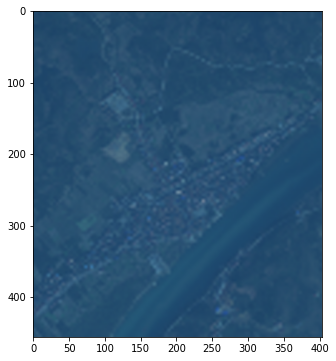

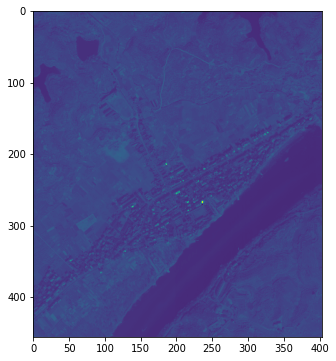

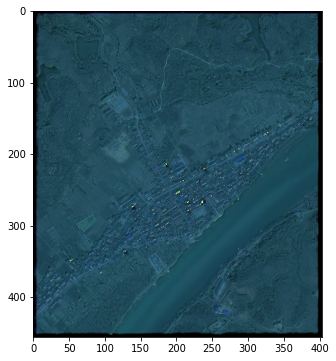

In [15]:
result1 = Image.open('/content/drive/MyDrive/ProjectWork/result/resultWTGAn/crop8bit_1.PNG')
fused= np.array(result1)
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_1.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0)
print(ms0.shape)
plt.figure(figsize=(6,6))
plt.imshow(fused)
print(ms0.shape)

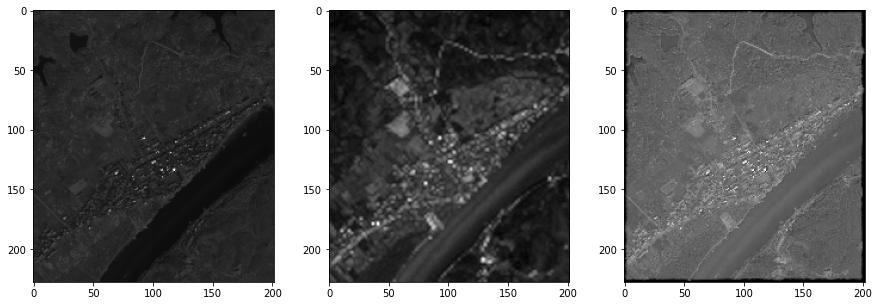

(228, 202) (228, 202) (228, 202)


In [16]:
import skimage.measure
p = skimage.measure.block_reduce(pan0, (2,2), np.max)
m = skimage.measure.block_reduce(ms0, (2,2,3), np.max)
f = skimage.measure.block_reduce(fused, (2,2,3), np.max)
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(p,cmap='gray')
ax[1].imshow(m.reshape(m.shape[0],m.shape[1]),cmap='gray')
ax[2].imshow(f.reshape(m.shape[0],m.shape[1]),cmap='gray')
plt.show()
m = m.reshape(m.shape[0],m.shape[1])
f = f.reshape(m.shape[0],m.shape[1])
print(p.shape,m.shape,f.shape)

In [17]:
entropy_p = skimage.measure.shannon_entropy(p)
entropy_m = skimage.measure.shannon_entropy(m)
entropy_f = skimage.measure.shannon_entropy(f)
print(f"pan =>{entropy_p:.2f}")
print(f"ms =>{entropy_m:.2f}")
print(f"fused =>{entropy_f:.2f}")

pan =>5.13
ms =>4.36
fused =>5.95


In [ ]:
print("STD_ms", m.std())
print("STD_pan", p.std())
print("STD_fused", f.std())




STD_ms 5.886416846055631
STD_pan 0.08694950842630733
STD_fused 24.447401641371744


(348, 240, 3)
(348, 240, 3)
(348, 240, 3)


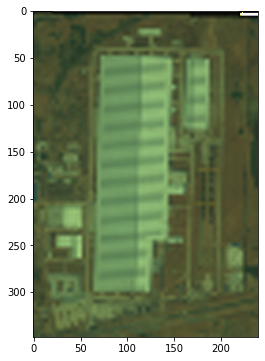

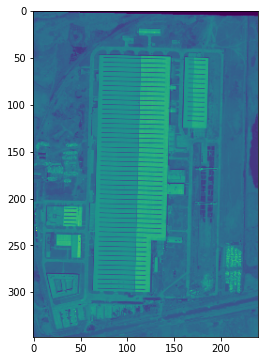

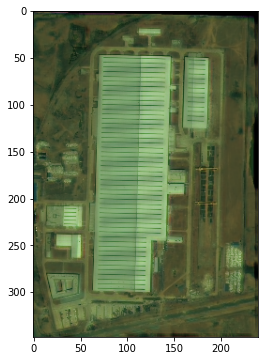

In [ ]:
result1 = Image.open('/content/drive/MyDrive/ProjectWork/result/resultsWTGAN/crop8bit_2.PNG')
fused= np.array(result1)
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_2.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0)
print(ms0.shape)
plt.figure(figsize=(6,6))
plt.imshow(fused)
print(ms0.shape)

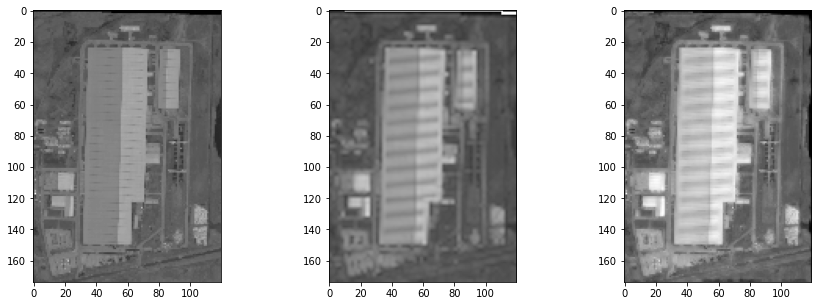

(174, 120) (174, 120) (174, 120)


In [ ]:
import skimage.measure
p = skimage.measure.block_reduce(pan0, (2,2), np.max)
m = skimage.measure.block_reduce(ms0, (2,2,3), np.max)
f = skimage.measure.block_reduce(fused, (2,2,3), np.max)
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(p,cmap='gray')
ax[1].imshow(m.reshape(m.shape[0],m.shape[1]),cmap='gray')
ax[2].imshow(f.reshape(m.shape[0],m.shape[1]),cmap='gray')
plt.show()
m = m.reshape(m.shape[0],m.shape[1])
f = f.reshape(m.shape[0],m.shape[1])
print(p.shape,m.shape,f.shape)

In [ ]:
entropy_p = skimage.measure.shannon_entropy(p)
entropy_m = skimage.measure.shannon_entropy(m)
entropy_f = skimage.measure.shannon_entropy(f)
print(f"pan =>{entropy_p:.2f}")
print(f"ms =>{entropy_m:.2f}")
print(f"fused =>{entropy_f:.2f}")

pan =>5.86
ms =>6.73
fused =>7.04


In [ ]:
print("STD_ms", m.std())
print("STD_pan", p.std())
print("STD_fused", f.std())




STD_ms 36.45992738602279
STD_pan 0.15750947292323378
STD_fused 42.54097753739803
